# Energy-dependent third-factor STDP

Lets bombard one edlif neuron with multiple presynaptic neurons and measure the effect of different 
$\eta$ values in weights convergence and dynamics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import re
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential. Let's download the model from the NESTML repository so it becomes available locally:

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [2]:
module_name = "edlif_psc_alpha_0_module"
nest.Install(module_name)


Jan 25 13:41:47 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


In [3]:
def experiment(seed: int = 1,
              poisson_rate: float = 100,
              n_pre_neurons: int = 1000,
              mean_current: float = 545,
              std_current: float = 40,
              neuron_model: str = "edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml",
              syn_spec: dict = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
                               "alpha": 0.5,
                               "mu_minus": 0,
                               "mu_plus": 0,
                               "lambda": 0.01,
                               "eta": 20},
              sim_time: float = 2000):
    # reset kernel
    nest.ResetKernel()
    # set seeds
    nest.rng_seed = seed
    np.random.seed(seed)
    # create neurons
    neuron_pre = nest.Create(neuron_model, n_pre_neurons)
    neuron_post = nest.Create(neuron_model)
    # set neurons params
    for n in neuron_pre:
        n.I_e = np.random.normal(mean_current, std_current)
    #neuron_pre = nest.Create("poisson_generator", {"rate": poisson_rate})
    for neuron in [neuron_pre, neuron_post]:
        neuron.tau_m = 20 #20
        neuron.tau_syn_ex = 6
        neuron.tau_syn_in = 6
        neuron.C_m = 200 #250
        neuron.t_ref = 8 #2
        # energy params
        neuron.K_ATP = 1
        neuron.gamma = 0
        neuron.tau_ap = 100
        neuron.E_ap = 8
        neuron.E_rp = 5
        neuron.E_hk = 5
        neuron.E_syn_ex = 4
        neuron.E_syn_in = 4
        neuron.tau_syn_atp_ex = 100
        neuron.tau_syn_atp_in = 100
        
    # **OBS** post synaptic neurons also has his own I_e
    neuron_post.I_e = 175
    neuron_post.w_max = 100
    neuron_post.w_min = 100
    
    # recorders
    sr_post = nest.Create("spike_recorder")
    nest.Connect(neuron_post, sr_post)
    sr_pre = nest.Create("spike_recorder")
    nest.Connect(neuron_pre, sr_pre)
    mult = nest.Create('multimeter',
                      params={"record_from": ["ATP"]})
    nest.Connect(mult, neuron_post)
    wr = nest.Create("weight_recorder")
    nest.CopyModel(syn_spec["synapse_model"], "w_record", 
                  {"weight_recorder": wr})
    nest.Connect(neuron_pre, neuron_post, 
                 syn_spec={"synapse_model": "w_record"})
    syn = nest.GetConnections(source=neuron_pre,
                         target=neuron_post,
                         synapse_model="w_record")
    #print(syn)
    for param, value in syn_spec.items():
        if param != "synapse_model":
            nest.SetStatus(syn, {param: value})
    nest.Simulate(sim_time)
    sr_pre = sr_pre.get("events")
    sr_post = sr_post.get("events")
    mult = mult.get("events")
    wr = wr.get("events")
    fin_weights = nest.GetConnections(source=neuron_pre,
                                     target=neuron_post)
    return sr_pre, sr_post, mult, wr, fin_weights.get('w')

In [4]:
def plots(sr_pre, sr_post, fr, exp_fr, times, mult, wr, eta, fin_weights, eq_energy_level):
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ID")
    plt.plot(sr_pre['times'], sr_pre['senders'], '.', alpha=0.5)

    plt.figure()
    plt.title(fr"$\eta$ = {eta}") 
    plt.xlabel("time (ms)")
    plt.ylabel("ID")
    plt.plot(sr_post['times'], sr_post['senders'], '.', alpha=0.5)

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ATP")
    plt.plot(mult['times'], mult['ATP'])
    plt.axhline(eq_energy_level, c='grey', ls='--')
    
    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("post rate (Hz)")
    plt.plot(times, fr)
    plt.axhline(exp_fr, c='grey', ls='--')

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Weights")
    plt.plot(wr['times'], wr['weights'], '.')

    plt.figure()
    plt.xlabel("Weights")
    plt.ylabel("Frequency")
    plt.title(fr"$\eta$ = {eta}")
    plt.hist(fin_weights)    

In [5]:
def equall_dep_pot_energy_level(eta: float, alpha: float = 0.5, a_h: float = 100):
    """gives A* that is achieve when depression and 
    potentiation has the same energy level"""
    if eta == 0:
        return 0
    else:
        return a_h*(np.log(alpha)/eta + 1)

In [6]:
def firing_rate(post_spike_times, simtime, step:float = 0.1, time_window: float = 30.):
    idx_from_time_window = int(time_window/step)
    times = np.arange(start=0,
                     stop=simtime + step/2,
                     step=step)  # array with times
    fr = np.zeros(len(times))  # array with times
    cum_fr = np.zeros(len(times))  # array with times
    for spk in post_spike_times:
        idx_from_spk_time = int(spk/step)
        fr[idx_from_spk_time] += 1  
    for idx in range(len(times)):
        if idx <= idx_from_time_window:
            cum_fr[idx] = np.sum(fr[0:idx])
        else: 
            cum_fr[idx] = np.sum(fr[idx-idx_from_time_window:idx])
        
    cum_fr *= 1000. / time_window 
    return times, cum_fr

In [7]:
def e_fr_from_app(k=1, a_h=100, alpha=0.5, eta=100, e_ap=8):
    """
    aproximates firing rate. should be fine when mean(weights) are 
    close to zero
    """
    return -k*a_h*np.log(alpha)/(eta*e_ap)*1000

def e_fr_from(mean_fr, k=1, a_h=100, alpha=0.5, eta=100, e_ap=8, mu=0.5, N=1000, mean_w=2, max_w=100):
    """
    Better aproximation of post firing rate assuming all pre neurons has 
    close firing rate and low variance for w
    """
    return -(k*a_h*np.log(alpha)/(eta*e_ap)*1000 + (mu*N*mean_w*mean_fr/max_w))

def e_fr_final(w, spikes, simtime, k=1, a_h=100, alpha=0.5, eta=100, e_ap=8, mu=0.5, N=1000, max_w=100):
    """
    Best(?) aproximation of post firing rate
    """
    w_times_fr = 0
    for n in range(1, N+1):
        fr = sum(spikes["senders"] == n)/simtime*1000
        weight = w[n-1]
        w_times_fr += fr*weight
    return -(k*a_h*np.log(alpha)/(eta*e_ap)*1000 + (mu/max_w*w_times_fr))


Jan 25 13:41:48 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Jan 25 13:41:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 30
    Number of OpenMP threads: 1
    Not using MPI

Jan 25 13:41:48 SimulationManager::run [Info]: 
    Simulation finished.


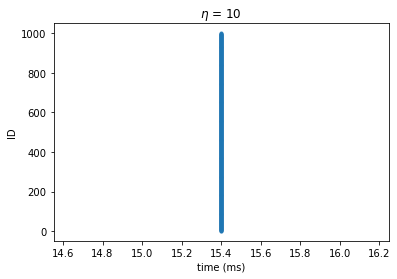

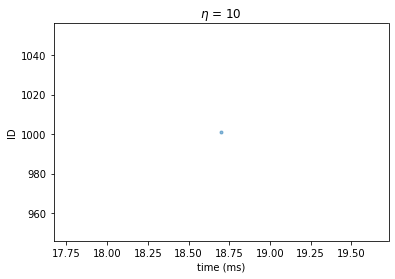

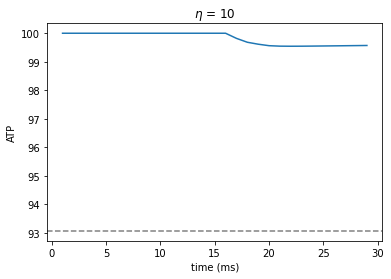

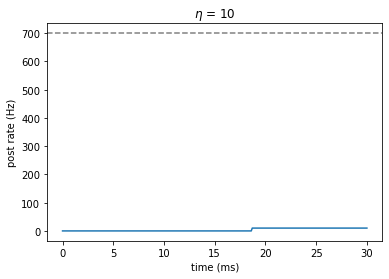

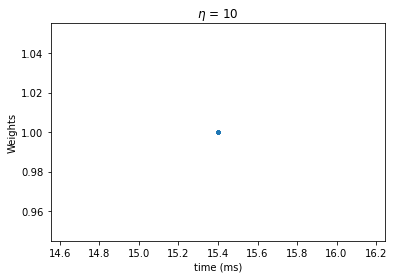

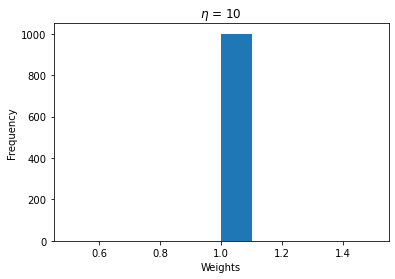

In [8]:
sim_time = 30
eta = 10
#n_pre_neurons = 2
mean_current = 280
std_current = 0
alpha = 0.5
n_pre_neurons = 1000
mu_plus = 0.02
mu_minus = 0.02

syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
           "alpha": alpha,
           "mu_minus": mu_minus,
           "mu_plus": mu_plus,
           "lambda": 0.01,
           "eta": eta}
eq_energy_level = equall_dep_pot_energy_level(eta=eta,
                                              alpha=alpha,
                                              a_h=100)
sr_pre, sr_post, mult, wr, fin_weights = experiment(
                                       n_pre_neurons=n_pre_neurons,
                                       mean_current=mean_current,
                                       std_current=std_current,
                                       sim_time=sim_time,
                                       syn_spec=syn_spec)

times, fr = firing_rate(post_spike_times=sr_post['times'], simtime=sim_time, time_window=100)
e_post_fr_final = e_fr_final(w=fin_weights, 
                             spikes=sr_pre, 
                             simtime=sim_time,
                             k=1,
                             a_h=100,
                             alpha=alpha,
                             eta=eta,
                             e_ap=8,
                             mu=0.5,
                             N=n_pre_neurons,
                             max_w=100)

plots(sr_pre=sr_pre, 
      sr_post=sr_post,
      fr=fr,
      exp_fr=e_post_fr_final,
      times=times,
      mult=mult, 
      wr=wr, 
      eta=eta, 
      fin_weights=fin_weights, 
      eq_energy_level=eq_energy_level)


Jan 25 13:41:50 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Jan 25 13:41:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 12000
    Number of OpenMP threads: 1
    Not using MPI

Jan 25 13:41:58 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 0
########################
expected eq. energy: 0
mean_lasts_atp : 0.0
mean post-synaptic fr = 122.41666666666666
last post-synaptic fr = 120.0
mean_pre_fr: 30.199333333333332

Jan 25 13:41:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Jan 25 13:41:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 12000
    Number of OpenMP threads: 1
    Not using MPI

Jan 25 13:42:05 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 1
########################
expected eq. energy: 30.68528194400547
mean_lasts_atp : 31.46310024680872
m

/tmp/ipykernel_24629/2229221067.py:14: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Jan 25 13:42:22 NodeManager::prepare_nodes [Info]: 
    Preparing 1005 nodes for simulation.

Jan 25 13:42:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1005
    Simulation time (ms): 12000
    Number of OpenMP threads: 1
    Not using MPI

Jan 25 13:42:28 SimulationManager::run [Info]: 
    Simulation finished.
Results for eta = 100
########################
expected eq. energy: 99.30685281944005
mean_lasts_atp : 99.23803444601349
mean post-synaptic fr = 50.0
last post-synaptic fr = 50.0
mean_pre_fr: 30.199333333333332


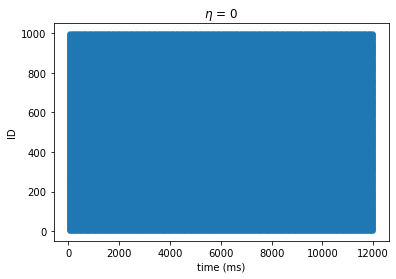

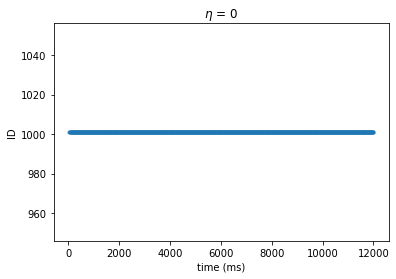

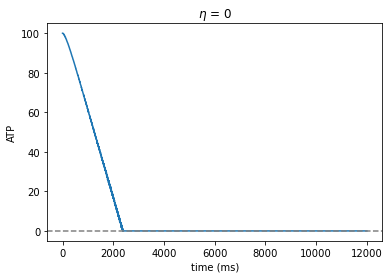

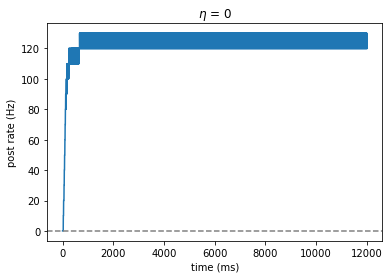

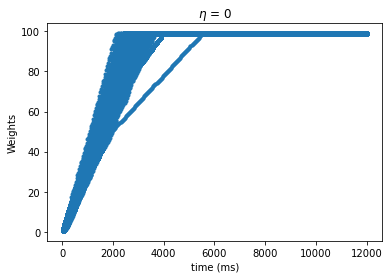

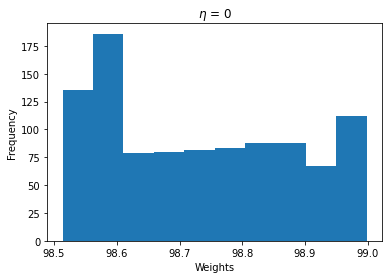

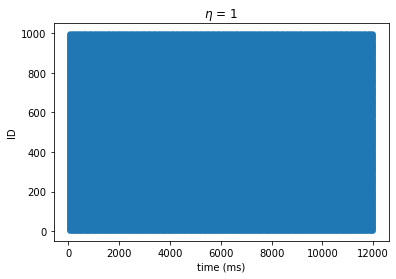

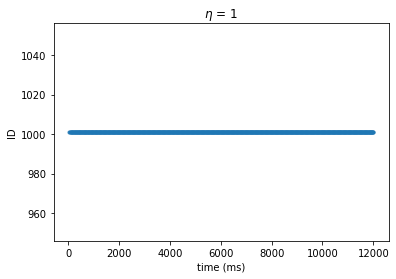

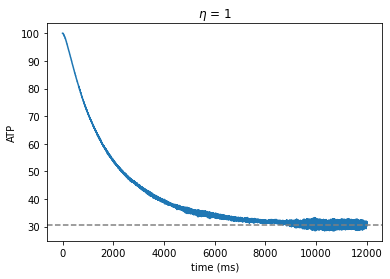

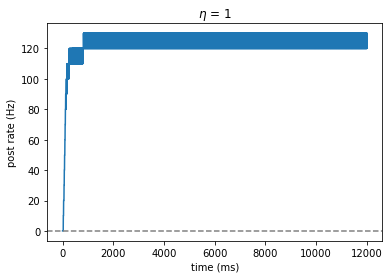

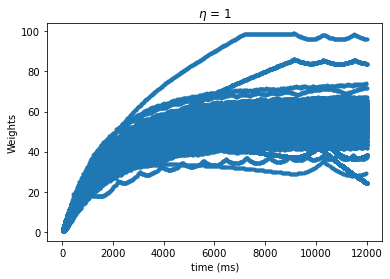

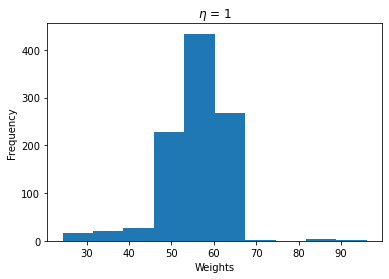

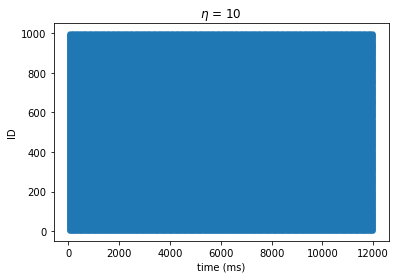

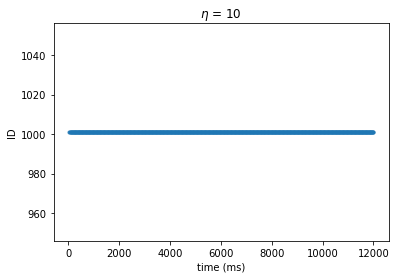

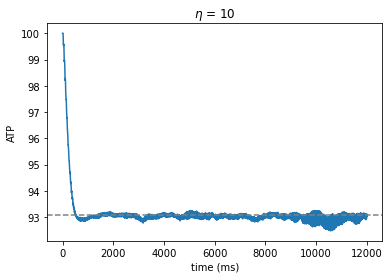

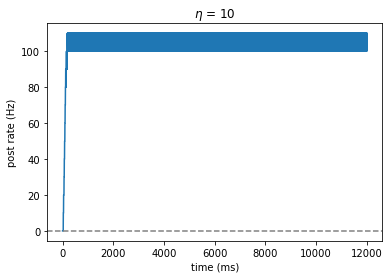

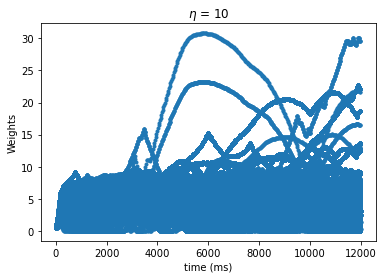

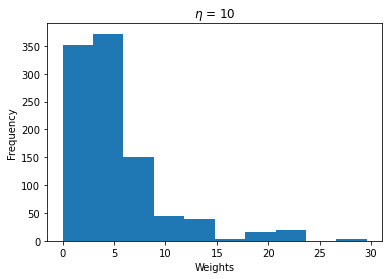

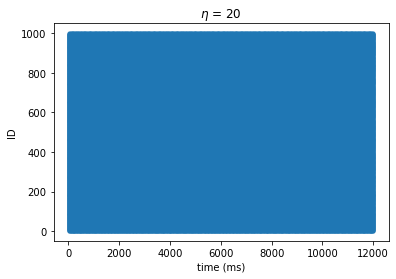

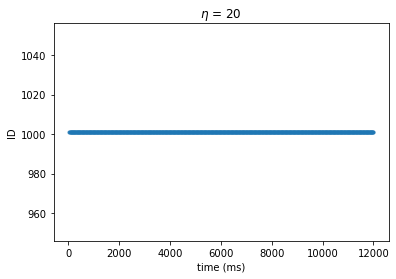

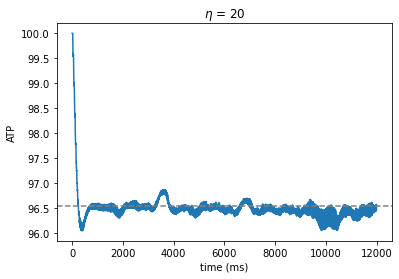

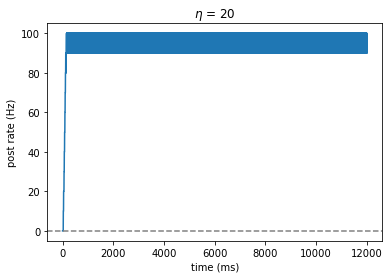

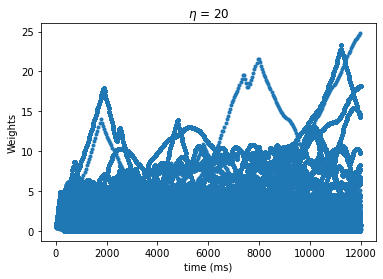

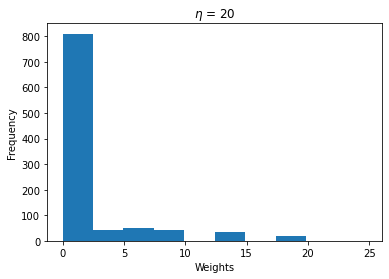

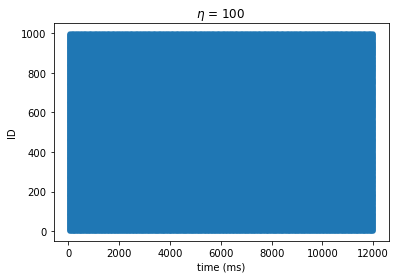

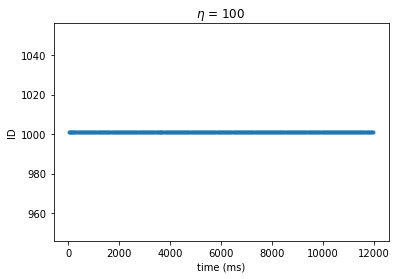

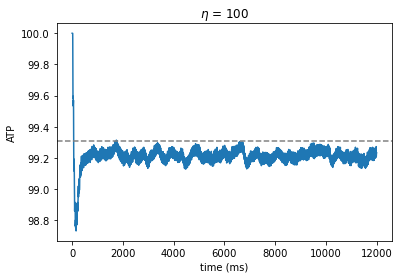

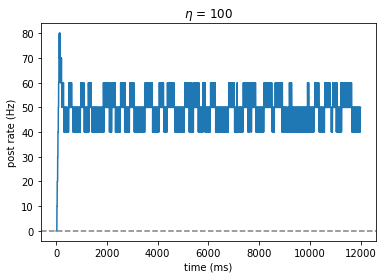

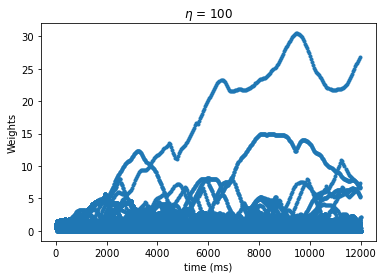

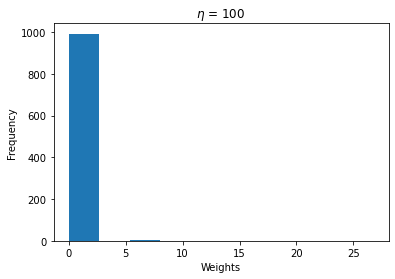

In [9]:
sim_time = 12000
mean_current = 210
std_current = 10
n_pre_neurons = 1000
#etas = [0, 1, 2, 5, 10, 20, 40, 80, 100, 200, 1000]
etas = [0, 1, 10, 20, 100]
mult_tot = []
wr_tot = []
fin_weights_tot = []
eq_energy_level = []
real_post_frs = []
real_post_frs_time = []
fr_times = []
e_app_post_frs = []
e_post_frs = []
e_post_frs_max = []
e_post_frs_min = []
e_post_frs_final = []
alpha = 0.5
mu_plus = 0 #0.02
mu_minus = 0 #0.02
for eta in etas:
    syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
               "alpha": alpha,
               "mu_minus": mu_minus,
               "mu_plus": mu_plus,
               "lambda": 0.01,
               "eta": eta}
    sr_pre, sr_post, mult, wr, fin_weights = experiment(
                                       sim_time=sim_time,
                                       mean_current=mean_current,
                                       std_current=std_current,
                                       syn_spec=syn_spec,
                                       n_pre_neurons=n_pre_neurons)
    print(f"Results for eta = {eta}")
    print("########################")
    mult_tot.append(mult)
    wr_tot.append(wr)
    fin_weights_tot.append(fin_weights)
    eq_energy = equall_dep_pot_energy_level(eta=eta,
                                            alpha=alpha,
                                            a_h=100)
    print(f"expected eq. energy: {eq_energy}")
    mean_lasts_atp = np.sum(mult['ATP'][-20:-1])/len(mult['ATP'][-20:-1])
    print(f"mean_lasts_atp : {mean_lasts_atp}")
    
    eq_energy_level.append(eq_energy)
    real_post_fr = len(sr_post['times'])/sim_time*1000
    real_post_frs.append(real_post_fr)
    print(f"mean post-synaptic fr = {real_post_fr}")
    times, fr = firing_rate(post_spike_times=sr_post['times'], simtime=sim_time, time_window=100)
    real_post_frs_time.append(fr)
    fr_times.append(times)
    print(f"last post-synaptic fr = {fr[-1]}")
#    e_app_post_fr = e_fr_from_app(k=1,
#                      a_h=100,
#                      alpha=alpha,
#                      eta=eta,
#                      e_ap=8)
#    print(f"expected post-synaptic fr (mean(w) close 0) = {e_app_post_fr}")
#    e_app_post_frs.append(e_app_post_fr)
    mean_fr = len(sr_pre['times'])/n_pre_neurons/sim_time*1000
    print(f'mean_pre_fr: {mean_fr}')
#    e_post_fr = e_fr_from(mean_fr=mean_fr,
#                          k=1,
#                          a_h=100,
#                          alpha=alpha,
#                          eta=eta,
#                          e_ap=8,
#                          mu=0.5,
#                          N=n_pre_neurons ,
#                          mean_w=np.mean(fin_weights_tot[-1]), # incoming
#                          max_w=100)
#    e_post_fr_max = e_fr_from(mean_fr=mean_fr,
#                          k=1,
#                          a_h=100,
#                          alpha=alpha,
#                          eta=eta,
#                          e_ap=8,
#                          mu=0.5,
#                          N=n_pre_neurons ,
#                          mean_w=max(0, np.mean(fin_weights_tot[-1])-np.std(fin_weights_tot[-1])), # incoming - std
#                          max_w=100)
#    e_post_fr_min = e_fr_from(mean_fr=mean_fr,
#                          k=1,
#                          a_h=100,
#                          alpha=alpha,
#                          eta=eta,
#                          e_ap=8,
#                          mu=0.5,
#                          N=n_pre_neurons,
#                          mean_w=np.mean(fin_weights_tot[-1])+np.std(fin_weights_tot[-1]), # incoming + std
#                          max_w=100)
#    print(f"expected post-synaptic fr (close pre fr and low variance for w) = {e_post_fr}")
#    print(f"expected post-synaptic fr <= {e_post_fr_max}")
#    print(f"expected post-synaptic fr >= {e_post_fr_min}")
#    print(f"Mean weights -> {np.mean(fin_weights_tot[-1])}")
#    print(f"std weights -> {np.std(fin_weights_tot[-1])}")
#    e_post_frs.append(e_post_fr)
    
#    e_post_fr_final = e_fr_final(w=fin_weights_tot[-1], 
#                                 spikes=sr_pre, 
#                                 simtime=sim_time,
#                                 k=1,
#                                 a_h=100,
#                                 alpha=alpha,
#                                 eta=eta,
#                                 e_ap=8,
#                                 mu=0.5,
#                                 N=n_pre_neurons,
#                                 max_w=100)
#    print(f"expected post-synaptic fr (different rates and high weight variance) = {e_post_fr_final}")
#    e_post_frs_final.append(e_post_fr_final)
    plots(sr_pre=sr_pre, 
      sr_post=sr_post,
      fr=fr,
      mult=mult, 
      wr=wr, 
      eta=eta, 
      fin_weights=fin_weights, 
      eq_energy_level=eq_energy,
      exp_fr=0,  #e_post_fr_final, 
      times=times)

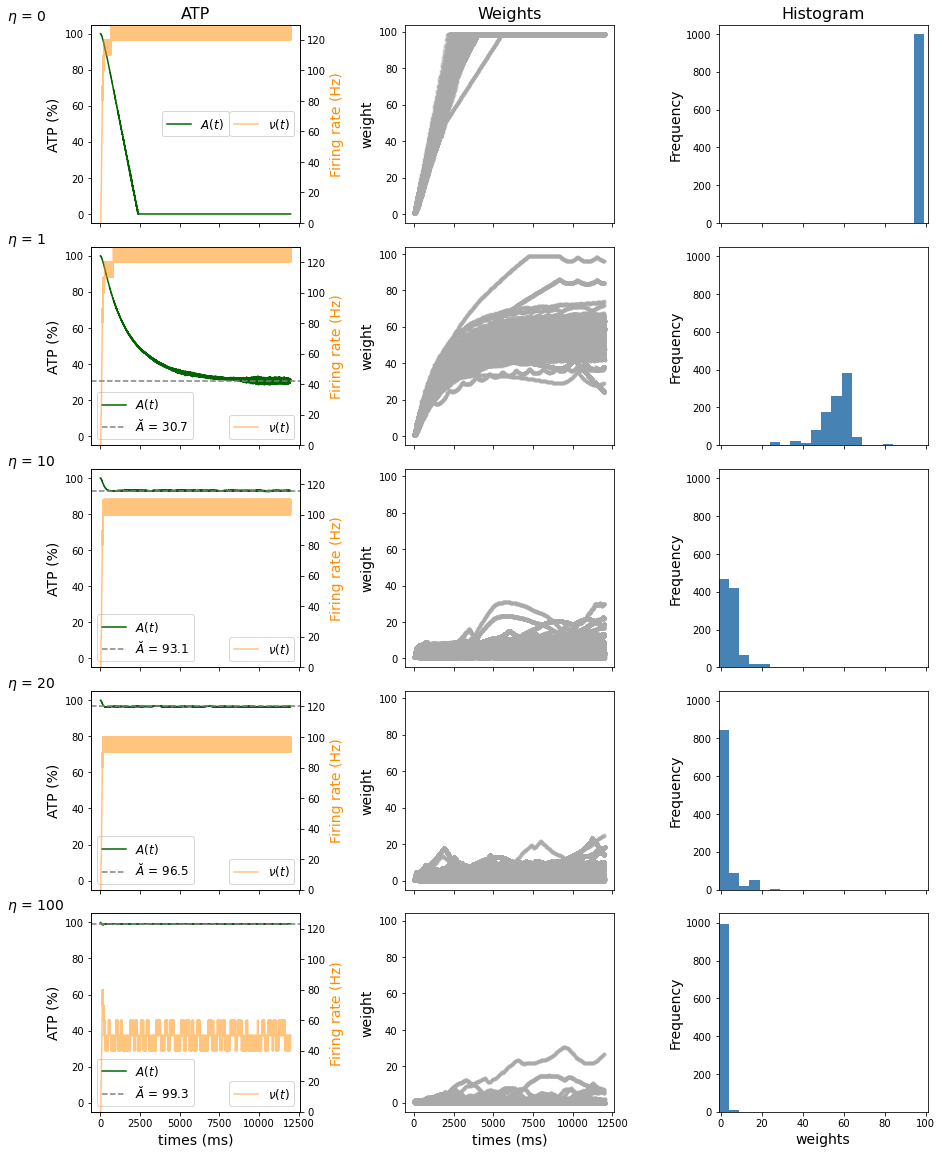

In [10]:
#mult_tot.append(mult)
#wr_tot.append(wr)
#fin_weights_tot.append(fin_weights)
label_size = 14
title_size = 16
legend_size = 12
ann_size = 14
bins = np.arange(-1, 101, 5)
fig, ax = plt.subplots(len(etas), 3, figsize=(15, 20), 
                       sharex='col', sharey='col')
#fig.tight_layout(pad=10.0)
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=0.12)
for row, eta in enumerate(etas):
    for_plot = [mult_tot[row], wr_tot[row], fin_weights_tot[row]]
    for col in range(3):
        if col == 0:
            #ax[row, col].set_ylim(81, 101)
            #ax[row, col].set_xlim(0, sim_time)
            ax[row, col].plot(mult_tot[row]['times'], 
                              mult_tot[row]['ATP'],
                             label=r'$A(t)$',
                             color='darkgreen')
            if eta == 0:    
                loc1 = "center"
                loc2 = "center right"
            else:
                ax[row, col].axhline(eq_energy_level[row], 
                                     c='grey', 
                                     ls='--',
                                    label=r'$\breve{A}$' + f' = {round(eq_energy_level[row], 1)}')
                loc1 = "lower left"
                loc2 = "lower right"
            ax[row, col].set_ylabel('ATP (%)',
                                   fontsize=label_size)
            ax[row, col].legend(fontsize=legend_size,
                               loc =loc1)
            ax[row, col].annotate(f'$\eta$ = {eta}',
                                  xy=(-.4, 1.08), 
                                  xycoords='axes fraction',
                                  horizontalalignment='left', 
                                  verticalalignment='top',
                                  fontsize=ann_size)
            ax_1_2 = ax[row, col].twinx()
            ax_1_2.set_ylim(min(real_post_frs_time[0]), 
                            max(real_post_frs_time[0]))
            ax_1_2.tick_params(axis='both')
            #ax_1_2.axhline(e_post_frs[row], c='darkorange', ls='-.', alpha=0.5)
            #ax_1_2.axhline(real_post_frs[row], c='darkgrey', alpha=0.5)
            ax_1_2.plot(fr_times[row],
                        real_post_frs_time[row],
                        c='darkorange', 
                        alpha=0.5,
                       label=r'$\nu (t)$')
            ax_1_2.set_ylabel('Firing rate (Hz)',
                              color='darkorange',
                              fontsize=label_size)
            ax_1_2.legend(fontsize=legend_size,
                               loc =loc2)
            if row == 0:
                ax[row, col].set_title('ATP',
                                   fontsize=title_size)
            if row == len(etas) - 1:
                ax[row, col].set_xlabel('times (ms)',
                                   fontsize=label_size)
            
                
        elif col == 1:
            ax[row, col].plot(wr_tot[row]['times'], 
                              wr_tot[row]['weights'], '.',
                             color='darkgrey',
                             alpha=0.5)
        
            ax[row, col].set_ylabel('weight',
                                   fontsize=label_size)
            if row == 0:
                ax[row, col].set_title('Weights',
                                   fontsize=title_size)
            if row == len(etas) - 1:
                ax[row, col].set_xlabel('times (ms)',
                                   fontsize=label_size)
                
        else:
            ax[row, col].hist(fin_weights_tot[row],
                             bins=bins,
                             facecolor='steelblue')
            ax[row, col].set_xlim(-1, 101)
            
            ax[row, col].set_ylabel('Frequency',
                                   fontsize=label_size)
            if row == 0:
                ax[row, col].set_title('Histogram',
                                   fontsize=title_size)
            if row == len(etas) - 1:
                ax[row, col].set_xlabel('weights',
                                   fontsize=label_size)
                
plt.savefig(f"ed-stdp_all_etas", dpi=144,bbox_inches='tight',
           pad_inches=0)

In [11]:
prin(asd)

NameError: name 'prin' is not defined

In [ ]:
eq_energy_level = equall_dep_pot_energy_level(eta=10,
                                              alpha=0.5,
                                              a_h=100)
print(eq_energy_level)

eq_energy_level = equall_dep_pot_energy_level(eta=100,
                                              alpha=0.5,
                                              a_h=100)
print(eq_energy_level)

In [ ]:
print(set(sr_pre['senders']))
print('--------------')
print('total senders:')
print(len(set(sr_pre['senders'])))

In [ ]:
def drift_classic(alpha, tau, r, delta_t):
    if delta_t > 0:
        drift = (1-alpha)*tau*r**2 + r*np.exp(-delta_t/tau)
    else:
        drift = (1-alpha)*tau*(r**2) - alpha*r*np.exp(delta_t/tau)
    
    if drift > 0:
        drift = 1
    else:
        drift = 0
        
    return drift

In [ ]:
delta_t = np.linspace(-200, 200, 500)  # ms
alpha = 0.95
tau = 10  
r = 1  # Hz
lambd = 0.005
drift_c = []
samples = 40
w_init = 0.5
for d_t in delta_t:
    drift_per_dt = []
    w_init = 0.5
    for n in range(samples):
        dt = d_t
        drift_per_dt.append(drift_classic(
                                 alpha=alpha,
                                 tau=tau,
                                 delta_t=dt,
                                 #lambd=lambd,
                                 w=w_init))
        w_init = drift_per_dt[-1]
    mean_drift = np.mean(drift_per_dt)
    #drift_c.append(drift_per_dt)
    drift_c.append(mean_drift)

In [ ]:
plt.plot(delta_t, drift_c)

In [ ]:
def drift_classic(alpha, tau, r, delta_t):
    f_p = 1
    f_m = alpha
    T_p = r**(-1) * np.exp(-abs(delta_t)/tau) * (delta_t > 0)
    T_m = r**(-1) * np.exp(-abs(1/r - delta_t)/tau) * (delta_t < 0)
    drift = r**2*((f_p-f_m)*tau + f_p * T_p - f_m * T_m)
    return drift

In [ ]:
delta_t = np.linspace(-200, 200, 500)  # ms
alpha = 0.95
tau = 10  
r = 1  # Hz
lambd = 0.005
drift_c = []
#samples = 40
#w_init = 0.5
drift_per_dt = []
for d_t in delta_t:
    dt = d_t
    drift_per_dt.append(drift_classic(
                             alpha=alpha,
                             tau=tau,
                             r=r,
                             delta_t=dt))

    #mean_drift = np.mean(drift_per_dt)
    #drift_c.append(drift_per_dt)
    #drift_c.append(mean_drift)

In [ ]:
plt.plot(delta_t, drift_per_dt)

In [ ]:
def stdp(alpha, tau, delta_t, lambd):
    if delta_t > 0:
        dw = lambd * np.exp(-delta_t/tau)
    else:
        dw = -lambd * alpha * np.exp(delta_t/tau)
    return dw

In [ ]:
alpha = 0.95
#alpha = 1.05
tau = 10  
lambd = 0.005

pre_spikes = np.linspace(200, 400, 20)
delta_t = np.linspace(-200, 200, 400)
mean_w = []
w_init = 0
r = len(pre_spikes)/(pre_spikes[-1] - pre_spikes[0])*1000
print(f'firing rate: {r}')
for dt in delta_t:
    post_spikes = pre_spikes + dt
    dw = []
    if dt < 0:
        for post_s in post_spikes:
            for n, pre_s in enumerate(pre_spikes[0: n+1]):
                dw.append(stdp(
                                alpha=alpha,
                                tau=tau,
                                lambd=lambd,
                                delta_t=post_s-pre_s))
    else:
        for pre_s in pre_spikes:
            for n, post_s in enumerate(post_spikes[0: n+1]):
                dw.append(stdp(
                                alpha=alpha,
                                tau=tau,
                                lambd=lambd,
                                delta_t=post_s-pre_s))
            #dw.append(drift_classic(
            #                     alpha=alpha,
            #                     tau=tau,
            #                     r=r,
            #                     delta_t=(post_s-pre_s)))
    tot_dw = np.sum(dw)
    #mean_w.append(max(0, min(1, w_init + np.mean(dw))))
    mean_w.append(max(0, min(1, w_init + tot_dw)))
    
            

In [ ]:
plt.plot(delta_t, mean_w)

In [ ]:
alpha = 0.95
#alpha = 1.05
tau = 10  
lambd = 0.05


delta_t = np.linspace(-100, 100, 100) # ms
w = []


for dt in delta_t:
    w_init = 0
    dw = 0
    r = abs(1/dt)*1000
    pre_spikes = np.random.poisson(lam=max(1, r), size=100)#np.linspace(300, 30000, 20)
    pre_spikes = np.cumsum(pre_spikes)
    print(f'firing rate: {r}')
    print('pre spikes times')
    print(pre_spikes)
    post_spikes = pre_spikes + dt
    for pre_t in pre_spikes:
        for post_t in post_spikes:
            if pre_t < post_t:
                # potentiation
                dw += lambd * np.exp(-(post_t-pre_t)/tau)
            else:
                # deppresion
                dw += - alpha *lambd * np.exp((post_t-pre_t)/tau)
    w.append(max(0, min(1, w_init + dw)))

In [ ]:
plt.plot(delta_t, w)

In [ ]:
sum_w_ji = np.arange(start=.5, stop=50, step=0.01)  # incoming weights
nu = np.arange(start=0, stop=200, step=1) # Hz
a_h = 100
alpha = 0.5
k = 1
eta = 5
E_syn = 4
E_ap = 8
I_ex = 2000
u_r = -70
theta = -50
tau_m = 20
r = tau_m/200
tau_ref = 8
nu_from_atp = []
nu_from_phys = []
for s_wji in sum_w_ji:
    nu_atp = -a_h*np.log(alpha)*k/(eta*E_syn*s_wji)
    nu_from_atp.append(nu_atp*1000)
    nu_phys = (tau_ref + tau_m*np.log(max(r*I_ex/(r*I_ex - theta + u_r + 1.*s_wji), 0.001)))**-1
    nu_from_phys.append(nu_phys*1000)
    
plt.plot(sum_w_ji, nu_from_atp, label="ATP constraints")
plt.plot(sum_w_ji, nu_from_phys, label="Physical constraints")
plt.ylabel(r"$\nu$ (Hz)")
plt.xlabel(r"$\sum_j w_{ji}$")
plt.legend()

nu_atp = np.array(nu_from_atp)
nu_phys = np.array(nu_from_phys)

min_diff = 100
for n, (nu_a, nu_p) in enumerate(zip(nu_atp, nu_phys)):
        diff = np.abs(nu_a - nu_p)
        #print(f"diff: {diff}")
        #print(f"n: {n}")
        #print(f"m: {m}")
        if diff <= min_diff:
            min_diff = diff
            nu_atp_idx = n
            nu_phys_idx = n
            #print("new best")
            #print(f"min_diff: {min_diff}")
            #print(f"n: {n}")
        
print(f"'Best' fr (atp): {nu_atp[nu_atp_idx]}")
print(f"'Best' fr (phys): {nu_phys[nu_phys_idx]}")
print(f"'Best' sum_w_ji (atp): {sum_w_ji[nu_atp_idx]}")
print(f"'Best' sum_w_ji (phys): {sum_w_ji[nu_phys_idx]}")
      
expected_fr = e_fr_from(mean_fr=nu_atp[nu_atp_idx], 
                        k=k, 
                        a_h=a_h, 
                        alpha=alpha, 
                        eta=eta, 
                        e_ap=E_ap, 
                        mu=0.5, 
                        N=1,
                        mean_w=sum_w_ji[nu_atp_idx], 
                        max_w=1)
print(f"expected fr: {expected_fr}")

In [ ]:
a_h = 100
alpha = 0.5
k = 1
eta = 5
E_syn = 4
E_ap = 8
I_ex = 200
u_r = -70
theta = -50
tau_m = 20
cm = 200
r = tau_m/cm
tau_ref = 8
mean_fr = 20
mean_w = 5
expected_fr = e_fr_from(mean_fr=mean_fr, 
                        k=k, 
                        a_h=a_h, 
                        alpha=alpha, 
                        eta=eta, 
                        e_ap=E_ap, 
                        mu=0.5, 
                        N=1,
                        mean_w=mean_w, 
                        max_w=100)

In [ ]:
k = 1
a_h = 100
alpha = 0.5
eta = 70
e_ap = 8
e_syn = 4
e_atp = equall_dep_pot_energy_level(eta=eta, 
                                    alpha=alpha, 
                                    a_h=a_h)
e_app_post_fr = e_fr_from_app(k=k,
                      a_h=a_h,
                      alpha=alpha,
                      eta=eta,
                      e_ap=e_ap)
print(e_atp)
print(e_app_post_fr)